## Task

There is a need to provide statistically proved analysis that will test proposed hypothesis. Basing on results of this analysis it is required to provide recommendations for further implementation of new algorithm for some social network.

## Project description:

There is a log of events of news feed of some social network. Data science team developed a new algorithm that, they think, will increase CTR (number of likes/ number of views) metric.

The data is accumulated in the form of an array that looks like following:

<img src="https://i.ibb.co/pJrwvNR/Screenshot-2023-06-23-at-18-54-23.png" alt="Screenshot-2023-06-23-at-18-54-23" border="0">

Where:

 - user_id - user's unique id
 - post_id - shown post's unique id
 - action - user's action
 - time - time of action
 - gender - user's gender
 - age - age of user
 - country - country in which user is located
 - city - city in which user is located
 - os - operation system installed on user's device
 - source - type of user's attraction to social network
 - exp_group - belonging to experimental group for further A/B testing

## Stack:

Python, Pandas, Matplotlib, Statsmodels, ClickHouse(SQL queries)

# A/A test

Data science team developed a new algorithm that, they think, will increase CTR (number of likes/ number of views) metric.

Using Salted Hash method all users were split into 5 groups ('0', '1', '2' ,'3', '4'). Feature of group number was placed in a column named 'exp_group'.

## The purpose of the study

Before providing the A/B test it is required to check whether users were split correctly between groups for compliance with the following criteria:


 - the size of groups are approximately the same
 - key metrics between group are equal
 
 
Or in other words it is necessary to perform an **A/A test**

## Data overview

 - It is defined that providing A/A test **from '2023-02-23' to '2023-03-01'**  will give statistically significant results
 - Experimental **groups '2' and '3'** were chosen for this test

## Research plan

Data about users' activity is presented in Clickhouse. Therefore, it is needed to set the connection and write a query to import data. 

It is known that quality of data is good and it doesn't require preprocessing before analysis.

Thus, the study will go in several stages:

- Data import
- Visual data analysis
- A/A tests

___
### Data import
___

First, let's import all necessary libraries:

In [5]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

Then we need to set up the connection

In [6]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database': 'simulator_20230320',
              'user':'student',
              'password':'dpo_python_2020'
             }

And write a query using SQL syntax. 

In [7]:
query = '''
SELECT  exp_group,
        user_id,
        sum(action='like') as likes,
        sum(action='view') as views,
        likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-02-23' AND '2023-03-01' AND
        exp_group IN (2,3)
GROUP BY exp_group, user_id
'''

After these manipulations we can import data:

In [8]:
df = ph.read_clickhouse(query, connection = connection)

___
### Visual data analysis
___

Let's take a look at data

In [9]:
df.sample()

,exp_group,user_id,likes,views,ctr
12553,3,115986,30,172,0.174419


We can see that dataframe contains column 'ctr'. At a quick glance calculations in this column are performed correctly.

Next, we have to make sure that number of users within experimental groups ('exp_group' column) are equal.

In [10]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


After that we need to make sure of key metric's similarity between groups. Visual comparance will take place first.

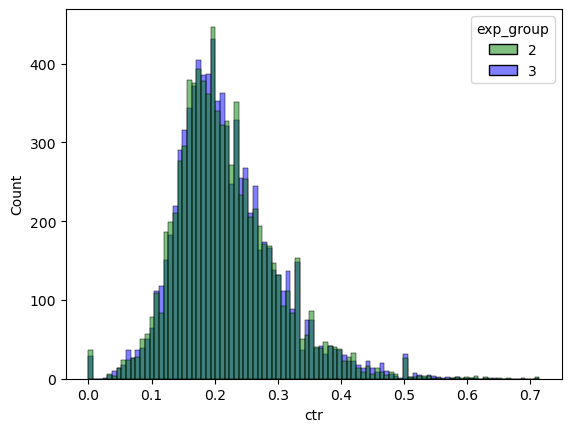

In [11]:
groups = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette=['g', 'b'],
                      alpha=0.5,
                      kde=False)

After that overall statistical test between two groups will be provided.

In [20]:
alpha = .05
ttest = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
if ttest[1] < alpha:
    print(f'p-value equals {ttest[1]}, null hypothesis can be rejected')
else:
    print(f'p-value equals {ttest[1]}, failed to reject null hypothesis')    

p-value equals 0.45969873156476293, failed to reject null hypothesis


P-value as a result of CTR statistical comparance using *t-test* between groups '2' and '3' exceeds predefind alpha level. This means null hypothesis failed to reject and there is no statistically significant difference between key metric of these two groups.

___
### A/A test
___

When conducting an A/A test, it would be great to make sure that our splitting system works correctly, and the key metric does not differ between groups, not only in our A/A test specifically, but also in general.

Ideally, it would be great to conduct an infinite number of A/A tests and see how many cases we managed to reject the null hypothesis. If the splitting system works correctly, then statistically significant differences between the two groups would occur only as a result of an accidental false positive. For example, if we reject the null hypothesis provided that p_value < 0.05, then only in about 5% of cases we would have statistically significant results.

It is clear that in practice we are unlikely to be able to conduct an infinite number of tests, so we will use a small trick! We will repeatedly extract subsamples from our data, conduct a t-test, and at the end we will see in what percentage of cases we managed to reject the null hypothesis.

So, we have A/A test data from '2023-02-23' to '2023-03-01'. We need to make a simulation as if we have conducted 10,000 A/A tests. At each iteration, we will form subsamples without repetition of 500 users from the 2nd and 3rd experimental groups. Then we will compare these subsamples by t-test.

In [13]:
# making a list to store p-values
p_values = []

# running 10000 А/А-tests simulation
for i in range(10000):
    # picking random 500 users from 2nd and 3rd groups, without repetitions
    group2 = df[df.exp_group == 2].sample(n=500, replace=False)
    group3 = df[df.exp_group == 3].sample(n=500, replace=False)
    
    # concatenating subsamples
    sample = pd.concat([group2, group3], axis=0)
    
    # performing t-test
    t_stat, p_val = stats.ttest_ind(sample[sample.exp_group == 2].ctr,
                              sample[sample.exp_group == 3].ctr,
                              equal_var=False)
    
    # storing p-value to a list
    p_values.append(p_val)

In [14]:
sample.head()

,exp_group,user_id,likes,views,ctr
2393,2,117002,24,137,0.175182
12280,2,123933,10,53,0.188679
17012,2,115304,23,63,0.365079
13183,2,17997,6,24,0.250000
3002,2,131819,9,38,0.236842


Now let's check if splitting system worked properly:

In [22]:
sample.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,500,500,500,500
3,500,500,500,500


And then let's make a hist plot of p-values distribution and count the share of p-values that are less than 0.05

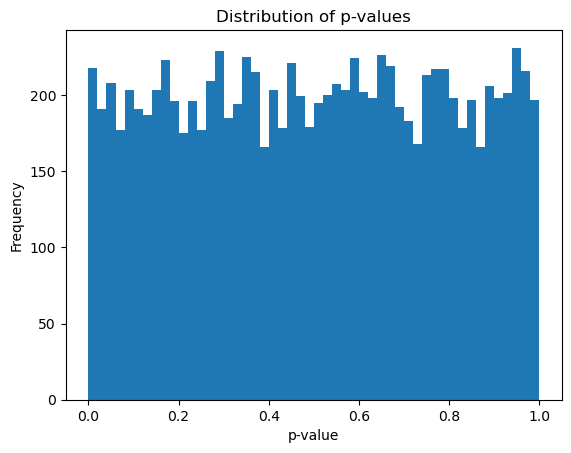

5.09% of p-values were <= 0.05


In [23]:
plt.hist(p_values, bins=50)
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values')
plt.show()

p_values = np.array(p_values)
pct_significant = round(np.mean(p_values <= 0.05) * 100, 2)
print(f'{pct_significant}% of p-values were <= 0.05')

We can see that **the splitting system worked correctly and the p-value above 0.05, which allows to reject the null hypothesis, appeared only in ~5% of cases, which can be interpreted as random triggers.**